In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from utils import handle_outliers, scale_columns, split_data, plot_predictions
from models import train_and_evaluate_svm, optimize_svr_nmse, run_arimax, optimize_arimax, run_backpropagation, optimize_backpropagation

## **Processing of the dataset**

In [3]:
%run dataset.py

[*********************100%***********************]  1 of 1 completed

S&P 500 data processed with RDP.
Data saved as 'processed_data_rdp.csv'.


In [4]:
data = pd.read_csv('data/processed_data_rdp.csv', index_col=0)
data.head()

,Close,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,,
2005-02-01,1189.410034,9.251176,1.797314,-0.549336,-0.070571,-1.054000,1.480793
2005-02-02,1193.189941,11.402198,1.628523,0.722583,0.862218,0.432633,0.686745
2005-02-03,1189.890015,7.089487,1.306029,1.231909,0.184395,0.519542,0.642527
2005-02-04,1203.030029,17.700814,2.703699,3.010612,2.172498,1.274530,0.414279
2005-02-07,1201.719971,14.341911,1.731183,3.262726,1.452061,1.309236,0.390989


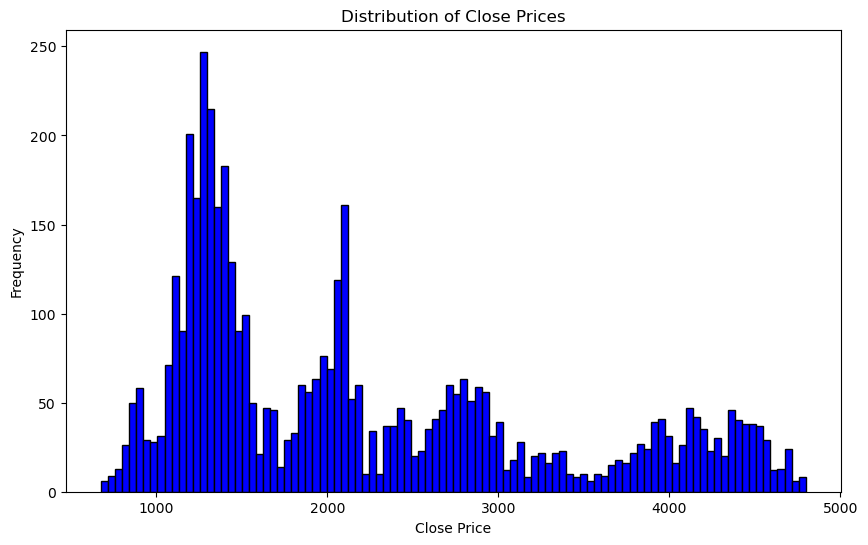

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(data['Close'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.show()

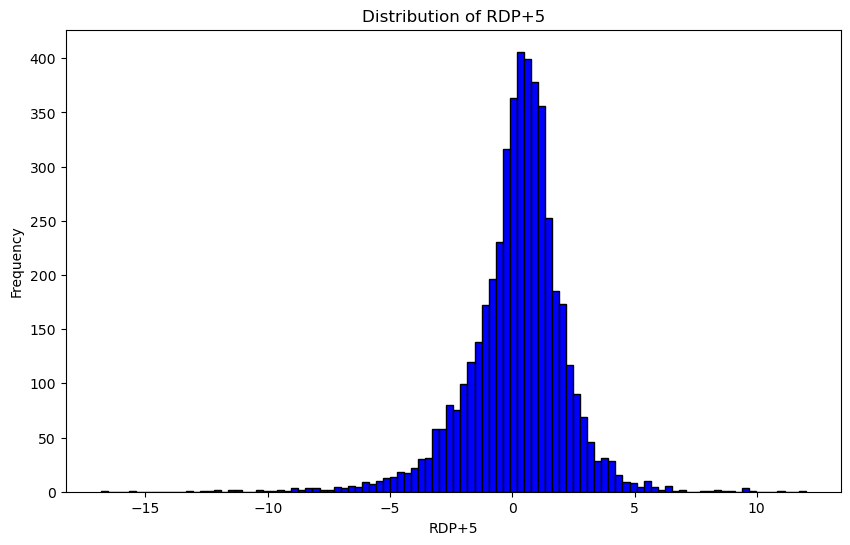

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(data['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

### **Outliers**

In [8]:
data_scaled = handle_outliers(data, columns=['RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = scale_columns(data_scaled, columns=['EMA15','RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = data_scaled.drop(columns=['Close'])
print(data_scaled.shape)
data_scaled.head()

(4756, 6)


,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,
2005-02-01,0.427594,0.298879,-0.122540,-0.065974,-0.171376,0.288841
2005-02-02,0.433592,0.267746,0.051282,0.038701,-0.024821,0.114253
2005-02-03,0.421567,0.208264,0.120888,-0.037362,-0.016253,0.104530
2005-02-04,0.451154,0.466056,0.363968,0.185738,0.058175,0.054345
2005-02-07,0.441788,0.286682,0.398423,0.104892,0.061596,0.049224


## Splitting the data into Training-Validation-Testing

In [10]:
train_data, val_data, test_data = split_data(data_scaled)

print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Testing data: {test_data.shape}')

Training data: (3329, 6)
Validation data: (713, 6)
Testing data: (714, 6)


In [11]:
features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']
target = 'RDP+5'

# Split data
y_train = train_data[target]
y_val = val_data[target]
y_test = test_data[target]

X_train = train_data[features]
X_val = val_data[features]
X_test = test_data[features]

## **SVM Regression Model**

Validation MSE: 0.1588
Validation NMSE: 0.9922
Validation R²: 0.0078
Test MSE: 0.1820
Test NMSE: 1.0480
Test R²: -0.0480


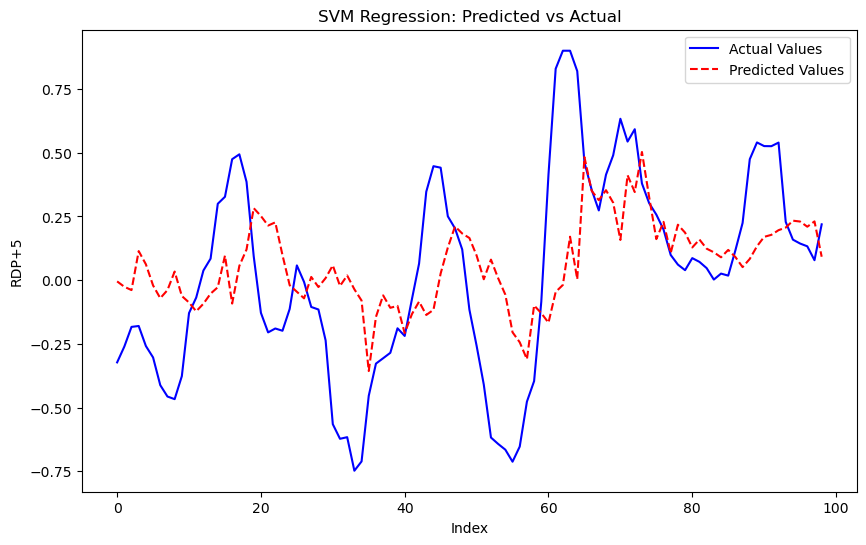

In [13]:
svr_results = train_and_evaluate_svm(train_data, val_data, test_data, features, target)
plot_predictions(svr_results['y_test'], svr_results['test_predictions'],name_model = "SVM Regression", start_idx=-100, end_idx=-1)

### **Optimisation of the Hyper-parameters**

In [15]:
# Define hyperparameter grid
param_grid = {
    "C": [0.001, 0.1, 1, 10],
    "epsilon": [0.001, 0.01, 0.1],
    "gamma": [0.001 ,0.01, 0.1, 1]
}
# Optimize hyperparameters
svr_optimized_results = optimize_svr_nmse(train_data, val_data, features, target, param_grid)

# Evaluate the best model on the test set
best_model = svr_optimized_results["best_model"]

# Test the model
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test NMSE: {test_nmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.001)...
NMSE: 1.0012
Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.01)...
NMSE: 0.9996
Evaluating SVR(C=0.001, epsilon=0.001, gamma=0.1)...
NMSE: 0.9923
Evaluating SVR(C=0.001, epsilon=0.001, gamma=1)...
NMSE: 0.9860
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.001)...
NMSE: 1.0010
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.01)...
NMSE: 0.9995
Evaluating SVR(C=0.001, epsilon=0.01, gamma=0.1)...
NMSE: 0.9922
Evaluating SVR(C=0.001, epsilon=0.01, gamma=1)...
NMSE: 0.9862
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.001)...
NMSE: 1.0014
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.01)...
NMSE: 0.9999
Evaluating SVR(C=0.001, epsilon=0.1, gamma=0.1)...
NMSE: 0.9929
Evaluating SVR(C=0.001, epsilon=0.1, gamma=1)...
NMSE: 0.9873
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.001)...
NMSE: 0.9909
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.01)...
NMSE: 0.9783
Evaluating SVR(C=0.1, epsilon=0.001, gamma=0.1)...
NMSE: 0.9669
Evaluating SVR(C=0.1, 

/Users/jimmybao/anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Test MSE: 0.1715
Test NMSE: 0.9875
Test R²: 0.0125


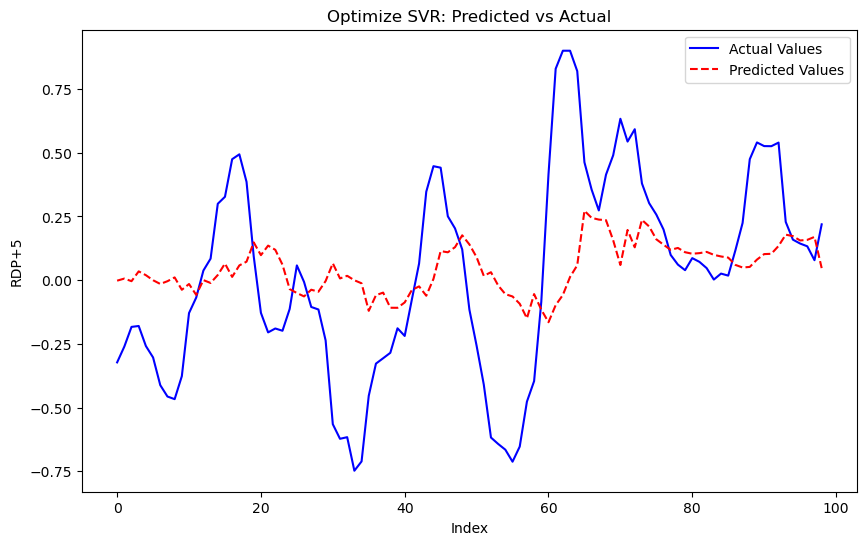

In [16]:
# Plot predictions for a specific range (e.g., last 100 data points)
plot_predictions(y_test, test_predictions, name_model="Optimize SVR",start_idx=-100, end_idx=-1)

## **Financial Time series (ARIMA/ARIMAX)**

In [17]:
import warnings
warnings.filterwarnings("ignore")  # Suppress ARIMA warnings during grid search

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.00300D-01    |proj g|=  2.12161D-01


 This problem is unconstrained.



At iterate    5    f= -6.10528D-01    |proj g|=  1.75696D-02

At iterate   10    f= -6.11396D-01    |proj g|=  2.48601D-02

At iterate   15    f= -6.11930D-01    |proj g|=  1.64681D-03

At iterate   20    f= -6.11942D-01    |proj g|=  2.44617D-03

At iterate   25    f= -6.11945D-01    |proj g|=  3.37067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     29      1     0     0   3.371D-04  -6.119D-01
  F = -0.61194539179149499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMAX ((1, 1, 1)) Test MSE: 0.3938
ARIMAX ((1, 1, 1)) Test R²: -1.2678
ARIMAX ((1, 1, 1)) Test NMSE: 2.2678


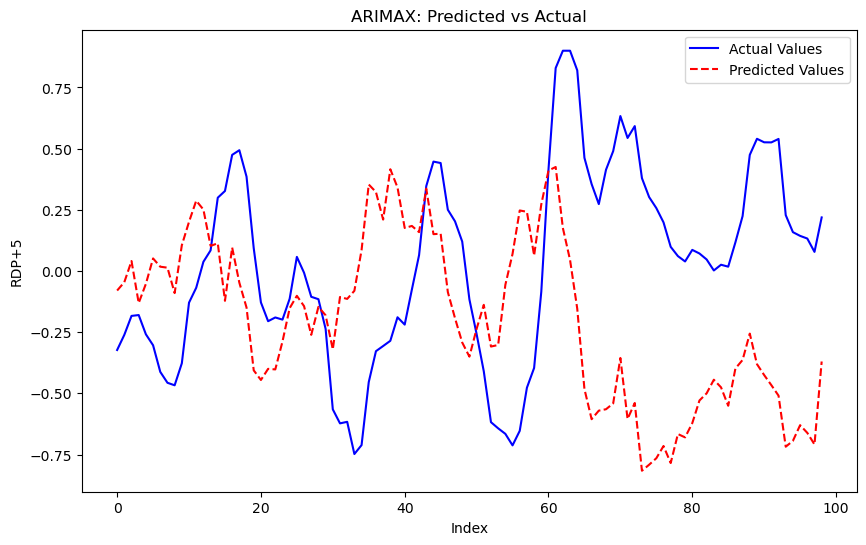

In [26]:
# Run ARIMAX
arimax_results = run_arimax(y_train, y_test, X_train, X_test, order=(1, 1, 1))
arimax_results['predictions'].reset_index(drop=True, inplace=True)
plot_predictions(y_test, arimax_results['predictions'], name_model = "ARIMAX", start_idx=-100, end_idx=-1)

In [27]:
# Optimize ARIMAX
param_grid_arimax = {
        "p_values": [1, 2, 3],
        "d_values": [0, 1],
        "q_values": [1, 2, 3]
    }

amimax_optimized_results = optimize_arimax(y_train, X_train, y_val, X_val, param_grid_arimax)

# Evaluate the final model on the test set
best_model = amimax_optimized_results['best_model']
test_predictions = best_model.forecast(steps=len(y_test), exog=X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test NMSE: {test_nmse:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

Evaluating ARIMAX(1,0,1)...
nmse: 3.4698480362012014
Evaluating ARIMAX(1,0,2)...
nmse: 3.1341970003570694
Evaluating ARIMAX(1,0,3)...
nmse: 3.093908274802355
Evaluating ARIMAX(1,1,1)...
nmse: 2.343924202810995
Evaluating ARIMAX(1,1,2)...
nmse: 1.9768701180704409
Evaluating ARIMAX(1,1,3)...
nmse: 1.8383717164928604
Evaluating ARIMAX(2,0,1)...
nmse: 2.575023530201146
Evaluating ARIMAX(2,0,2)...
nmse: 2.770844370333787
Evaluating ARIMAX(2,0,3)...
nmse: 2.2938637306430563
Evaluating ARIMAX(2,1,1)...
nmse: 2.2505396567909397
Evaluating ARIMAX(2,1,2)...
nmse: 2.331201592592474
Evaluating ARIMAX(2,1,3)...
nmse: 2.321521338897686
Evaluating ARIMAX(3,0,1)...
nmse: 2.569439122859722
Evaluating ARIMAX(3,0,2)...
nmse: 3.4783002214870633
Evaluating ARIMAX(3,0,3)...
nmse: 2.572527489668595
Evaluating ARIMAX(3,1,1)...
nmse: 1.9962487878079116
Evaluating ARIMAX(3,1,2)...
nmse: 1.896056695116383
Evaluating ARIMAX(3,1,3)...
nmse: 2.2370826099508383
Best ARIMAX Order: (1, 1, 3) with Validation NMSE: 1.83

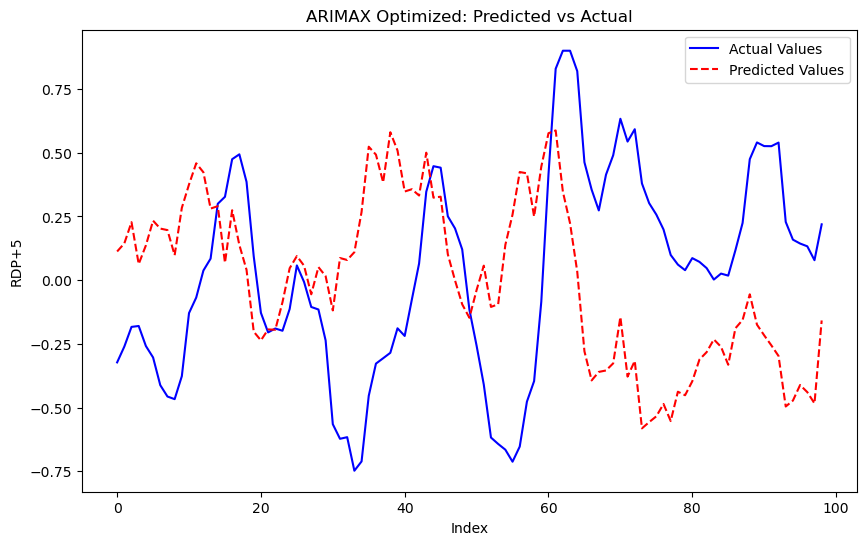

In [28]:
plot_predictions(y_test, amimax_optimized_results['best_model'].forecast(steps=len(test_data), exog=X_test), name_model = "ARIMAX Optimized", start_idx=-100, end_idx=-1)

## **Backpropagation (Neural Network)**

Epoch 1/150
105/105 - 1s - 14ms/step - loss: 1.0275 - nmse_metric: 1.0463 - val_loss: 1.2510 - val_nmse_metric: 1.2706
Epoch 2/150
105/105 - 0s - 2ms/step - loss: 1.0132 - nmse_metric: 1.0511 - val_loss: 1.2684 - val_nmse_metric: 1.2766
Epoch 3/150
105/105 - 0s - 2ms/step - loss: 1.0168 - nmse_metric: 1.0524 - val_loss: 1.1937 - val_nmse_metric: 1.2415
Epoch 4/150
105/105 - 0s - 2ms/step - loss: 0.9949 - nmse_metric: 1.0493 - val_loss: 1.2822 - val_nmse_metric: 1.3239
Epoch 5/150
105/105 - 0s - 2ms/step - loss: 1.0027 - nmse_metric: 1.0570 - val_loss: 1.2525 - val_nmse_metric: 1.2846
Epoch 6/150
105/105 - 0s - 2ms/step - loss: 0.9979 - nmse_metric: 1.0622 - val_loss: 1.1961 - val_nmse_metric: 1.2366
Epoch 7/150
105/105 - 0s - 2ms/step - loss: 1.0148 - nmse_metric: 1.0801 - val_loss: 1.2267 - val_nmse_metric: 1.2523
Epoch 8/150
105/105 - 0s - 2ms/step - loss: 0.9946 - nmse_metric: 1.0605 - val_loss: 1.2296 - val_nmse_metric: 1.2713
Epoch 9/150
105/105 - 0s - 2ms/step - loss: 0.9964 - nm

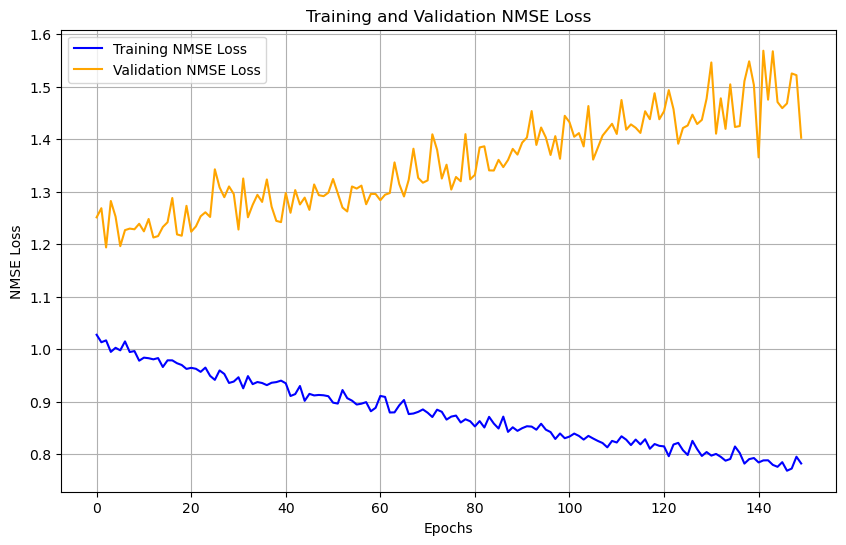

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
nmse: 1.0996872599770093
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Backpropagation Test MSE: 0.1966
Backpropagation Test R²: -0.1320
Backpropagation Test NMSE: 1.1320


In [29]:
# Run Backpropagation
backprop_results = run_backpropagation(train_data, val_data, test_data, features, target, epochs=150, batch_size=32, show_plots=True)

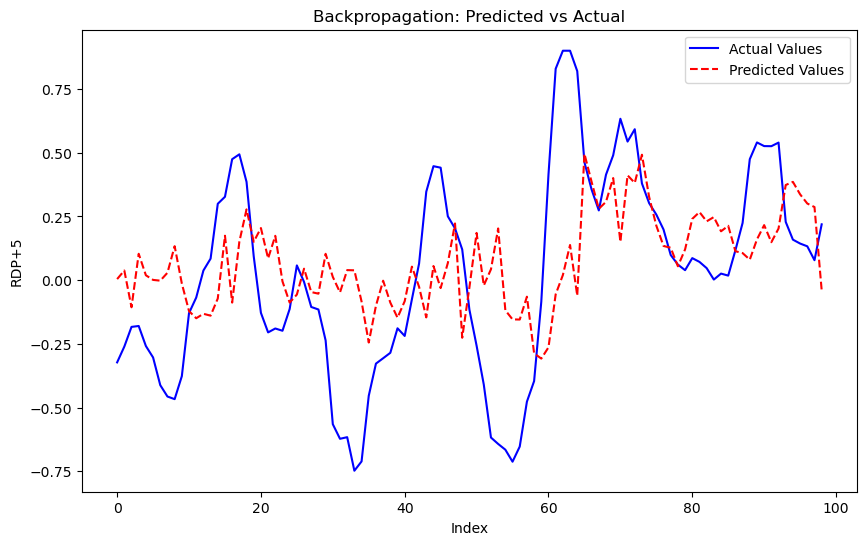

In [30]:
plot_predictions(y_test,backprop_results['predictions'], name_model = "Backpropagation", start_idx=-100, end_idx=-1)

Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.001, epochs:50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
nmse: 0.9933847472282088
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.001, epochs:100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
nmse: 1.041936119534022
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.001, epochs:150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
nmse: 1.1977209523010224
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.01, epochs:50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
nmse: 0.967934223797552
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.01, epochs:100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
nmse: 1.0379732017476304
Evaluating bp: (hidden_layers:(64, 32), batch_size:16, learning_rate:0.01, epochs:150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
nmse: 1.0573421076944225
Evaluating bp: (hidden_layers:(64, 32), batch_size:32, learning_rate:0.001, epochs:50
23/23 ━━━

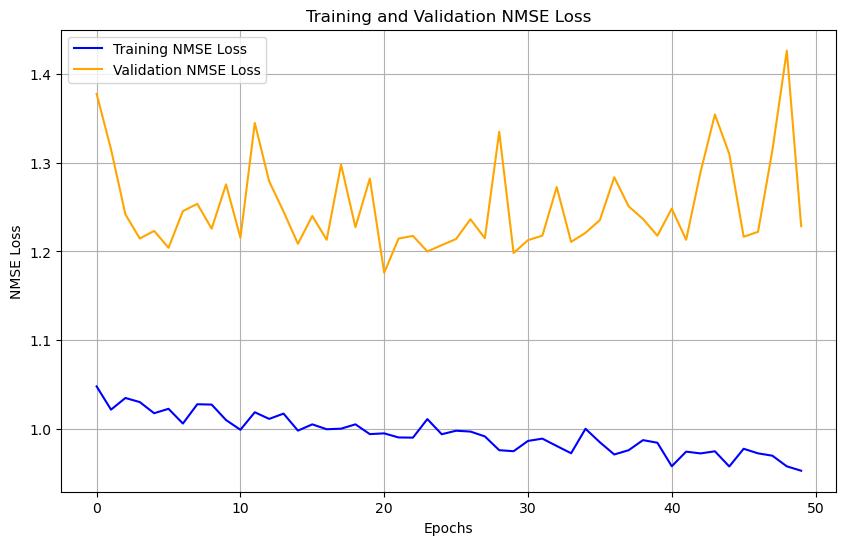

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test MSE: 0.1829
Test R²: -0.0531
Test NMSE: 1.0531


In [31]:
param_grid_bp = {
    "hidden_layers": [(64, 32), (128, 64)],
    "batch_size": [16, 32, 64],
    "learning_rate": [0.001, 0.01],
    "epochs": [50, 100, 150]
}
bp_optimized_results = optimize_backpropagation(train_data, val_data,test_data, features, target, param_grid_bp, show_plots=True)

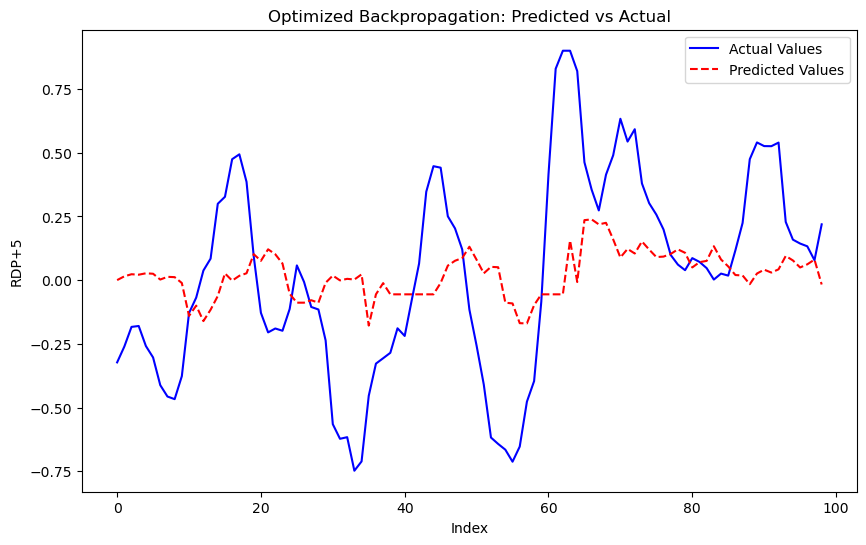

In [34]:
plot_predictions(y_test, bp_optimized_results['predictions'], name_model="Optimized Backpropagation", start_idx=-100, end_idx=-1)

## **Comparison of the models**

In [35]:
print("SVM Regression: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(svr_optimized_results['mse'], svr_optimized_results['r2'],svr_optimized_results['best_nmse'] ))
print("Backpropagation opt: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(bp_optimized_results['mse'], bp_optimized_results['r2'], bp_optimized_results['nmse']))
print("ARIMAX: MSE = {:.4f}, R² = {:.4f}, NMSE = {:.4f}".format(amimax_optimized_results['mse'], amimax_optimized_results['r2'], amimax_optimized_results['nmse']))

SVM Regression: MSE = 0.1513, R² = 0.0542, NMSE = 0.9458
Backpropagation opt: MSE = 0.1829, R² = -0.0531, NMSE = 1.0531
ARIMAX: MSE = 0.2942, R² = -0.8384, NMSE = 1.8384
